In [12]:
import numpy as np
import torch
import types
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets
import matplotlib.pyplot as plt
from time import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
train_dataset = datasets.MNIST(root = '.', train = True, download = True)
valid_dataset = datasets.MNIST(root = '.', train = False, download = True)
train_dataset.data = train_dataset.data.to(torch.float)
valid_dataset.data = valid_dataset.data.to(torch.float)

mean, std = train_dataset.data.mean(), train_dataset.data.std()
train_data = data.TensorDataset( (train_dataset.data-mean)/std, train_dataset.targets)
valid_data = data.TensorDataset( (valid_dataset.data-mean)/std, valid_dataset.targets)

train_loader = data.DataLoader(train_data, batch_size = 100, shuffle = True,  num_workers = 4, pin_memory=True)
valid_loader = data.DataLoader(valid_data, batch_size = 500, shuffle = False, num_workers = 4, pin_memory=True)

In [14]:
class LayerFlatten(torch.nn.Module):
    def forward(self, x): return x.view(x.shape[0], -1)
    
class LayerThicken(torch.nn.Module):
    def forward(self, x):
        if x.dim()==4:
            return x
        if x.dim()==3:
            return x[:,None,:,:]
        if x.dim()==2:
            n, m = x.shape
            return x[n, None, int(m**0.5), m-int(m**0.5)]

In [15]:
def LeNet300_100():
    model = nn.Sequential(
        LayerFlatten(),
        nn.Linear(784, 300),
        nn.ReLU(),
        nn.Linear(300, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
        nn.LogSoftmax(dim=-1))
    return model

def LeNet5():
    model = nn.Sequential( # 1, 28, 28
        LayerThicken(), 
        nn.Conv2d(1, 6, kernel_size=5, padding=2), # 6, 28, 28
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 6, 14, 14
        nn.Conv2d(6, 16, kernel_size=5), # 16, 10, 10
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 16, 5, 5
        LayerFlatten(),
        nn.Linear(400,120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.LogSoftmax(dim=-1)) 
    return model

In [16]:
class SNIP_official:
    def __init__(self, model):
        
        self.model = model
        self.pruned = []
        
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                layer.indicator = torch.ones_like(layer.weight)
                function = lambda self, x: F.linear(x, weight = self.weight * self.indicator, bias = self.bias)
                layer.forward = types.MethodType(function, layer)
                self.pruned.append(layer)
                
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                layer.indicator = torch.ones_like(layer.weight)
                function = lambda self, x: F.conv2d(x, self.weight * self.indicator, self.bias,
                                                  self.stride, self.padding, self.dilation, self.groups)
                layer.forward = types.MethodType(function, layer)
                self.pruned.append(layer)
                

    def prune(self, sparsity, loader, loss=nn.CrossEntropyLoss()):
        for layer in self.pruned:
                layer.indicator.requires_grad = True
                if layer.indicator.grad:
                    layer.indicator.grad.zero_()
        
        for x, y in loader:
            x = x.to(device); y = y.to(device)
            
            output = self.model.forward(x)
            L = loss(output, y)
            L.backward()
            break
            
        for layer in self.pruned: layer.indicator.requires_grad = False
        model.zero_grad()
            
        saliences = torch.empty(0)
        
        
        for layer in self.model:
            try: saliences = torch.cat([ saliences, layer.indicator.grad.view(-1).abs().to('cpu') ])
            except AttributeError: pass
        
        print('To prune', int(saliences.shape[0] * sparsity))
        limit_value = saliences.kthvalue(k = int(saliences.shape[0] * sparsity)).values.item()
        
        print("Connections statistics:")
        for layer in self.pruned:
            print( int(layer.indicator.sum().item()), end=' - ')
            print( (layer.indicator.grad.abs() < limit_value).sum().item(), end=' = ' )
            
            layer.indicator[layer.indicator.grad.abs() < limit_value] = 0
            print( (layer.indicator == 1).sum().item(), end = ' ' )
            print("(" + str(round( (layer.indicator == 1).sum().item() / layer.indicator.numel() * 100, 3)) + "%)")

    def apply(self):
        with torch.no_grad():
            for layer in self.pruned:
                layer.reset_parameters()
                layer.weight.data *= layer.indicator

In [23]:
model = LeNet5()
model.to(device);

In [24]:
snip = SNIP_official(model)
snip.prune(sparsity = 0.01, loader = train_loader)
snip.apply()

To prune 614
Connections statistics:
150 - 0 = 150 (100.0%)
2400 - 0 = 2400 (100.0%)
48000 - 0 = 48000 (100.0%)
10080 - 0 = 10080 (100.0%)
840 - 0 = 840 (100.0%)


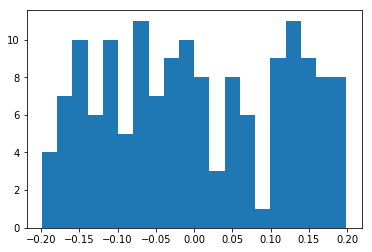

In [25]:
weights = np.array(model[1].weight.data.cpu().view(-1))
plt.hist(weights[weights!=0], bins=20);

# Training

In [26]:
def train(model, optimizer, scheduler, train_loader, valid_loader, epochs=1, loss=nn.CrossEntropyLoss()):
    
    for epoch in range(epochs):
        scheduler.step()
        
        model.train()
        cumloss, cumacc, quantity, t = 0, 0, 0, time()
        for x, y in train_loader:
            optimizer.zero_grad()
            x = x.to(device); y = y.to(device)
            
            probs = model.forward(x)
            L = loss(probs, y)
            L.backward()
            
            with torch.no_grad():
                optimizer.step()
                
                predictions = torch.argmax(probs, dim=1)
                accuracy = torch.sum((predictions==y).to(torch.float))
                
                cumloss += L.item()
                cumacc += accuracy.item() * 100
                quantity += predictions.shape[0]
                
                string = "\repoch {:^4} | item {:^7} | loss {:^6.3f} | accuracy {:^7.3f} | lr {:<7.5f}"
                print(string.format(epoch, quantity, cumloss/quantity, cumacc/quantity, optimizer.param_groups[0]['lr']), end='')
        
        model.eval()
        with torch.no_grad():
            cumloss, cumacc, quantity = 0, 0, 0
            for x, y in valid_loader:
                x = x.to(device); y = y.to(device)

                probs = model.forward(x)
                L = loss(probs, y)

                predictions = torch.argmax(probs, dim=1)
                accuracy = torch.sum((predictions==y).to(torch.float))

                cumloss += L.item()
                cumacc += accuracy.item() * 100
                quantity += predictions.shape[0]

            string = " || loss {:^7.4f} | accuracy {:^7.4f}"
            print(string.format(cumloss/quantity, cumacc/quantity), end='\n')

In [27]:
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [28]:
train(model, optimizer, scheduler, train_loader, valid_loader, epochs=20)

epoch  0   | item  60000  | loss 0.003  | accuracy 91.180  | lr 0.08000 || loss 0.0002  | accuracy 97.6800
epoch  1   | item  60000  | loss 0.001  | accuracy 97.763  | lr 0.06400 || loss 0.0001  | accuracy 98.3000
epoch  2   | item  60000  | loss 0.000  | accuracy 98.653  | lr 0.05120 || loss 0.0001  | accuracy 98.3800
epoch  3   | item  60000  | loss 0.000  | accuracy 98.913  | lr 0.04096 || loss 0.0001  | accuracy 98.6200
epoch  4   | item  60000  | loss 0.000  | accuracy 99.203  | lr 0.03277 || loss 0.0001  | accuracy 98.6600
epoch  5   | item  60000  | loss 0.000  | accuracy 99.448  | lr 0.02621 || loss 0.0001  | accuracy 98.9900
epoch  6   | item  60000  | loss 0.000  | accuracy 99.602  | lr 0.02097 || loss 0.0001  | accuracy 98.9700
epoch  7   | item  60000  | loss 0.000  | accuracy 99.723  | lr 0.01678 || loss 0.0001  | accuracy 98.9900
epoch  8   | item  60000  | loss 0.000  | accuracy 99.797  | lr 0.01342 || loss 0.0001  | accuracy 99.0600
epoch  9   | item  60000  | loss 0.00